In [1]:
# kaggle competitions submit -c [COMPETITION] -f [FILE] -m [MESSAGE]: make a competition submission



In [2]:
import pyarrow.parquet as pa
import pandas as pd



In [3]:
tbl = pa.read_table('jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet').to_pandas()

In [4]:
# schema = pa.read_schema('jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet')
# tbllags = pa.read_table('jane-street-real-time-market-data-forecasting/lags.parquet/date_id=0/part-0.parquet', schema=schema).to_pandas()

In [5]:
#symbol : financial instrument (20 in the parquet)
# Transformer - input - seq of n instruments, window (60) * n features, to predict outcome of each instrument
# embedding of window * n features (60 * 100) to a fixed size vector (1024)

# VAR model

In [6]:

tbl['symbol_id'].value_counts()

symbol_id
1     143481
16    141783
7     140934
19    139236
9     138387
0     138387
38    133293
33    115464
12    112068
13    110370
8     108672
10    102729
2      73863
17     68769
34     61128
3      60279
11     58581
14     54336
15     22074
30     20376
Name: count, dtype: int64

#### Drop columns with NA

In [7]:
# 78 features, 8 targets
# dropped 9 columns
drop_threshold = 0.5
print((tbl.isna().sum() <tbl.shape[0]*drop_threshold).sum(), tbl.shape[1])
tbl = tbl[tbl.columns[tbl.isna().sum() <tbl.shape[0]*drop_threshold]] 

84 93


#### Stationarity
Symbol 0:
feature_05 is nonstationary

In [36]:
# should add lags of time (to show gap in time)
# consider the lags issue by adding lags of responders
tbl['t'] = tbl['date_id'].astype(str) + tbl['time_id'].astype(str)
selected = tbl.loc[tbl['symbol_id'] == 0] #.loc[ tbl['date_id']==1]
selected_f =selected['feature_05']
selected_t = selected['t']
window = (0, 100)

#### ADF (Manual)

In [37]:
from statsmodels.tsa.stattools import adfuller

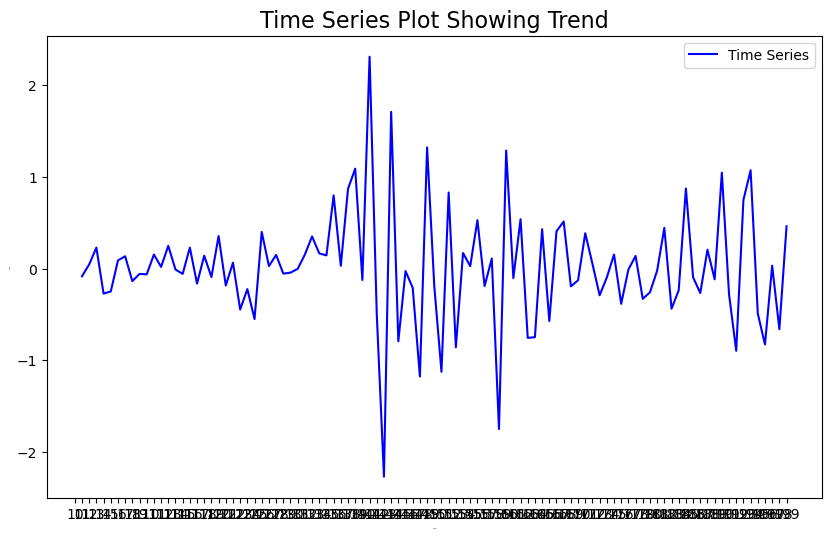

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(selected_t[window[0]:window[1]], selected_f[window[0]:window[1]].diff(), label="Time Series", color="blue")
plt.title("Time Series Plot Showing Trend", fontsize=16)
plt.xlabel("Time", fontsize=0)
plt.ylabel("Value", fontsize=12)
plt.legend()
plt.grid(False)
plt.show()

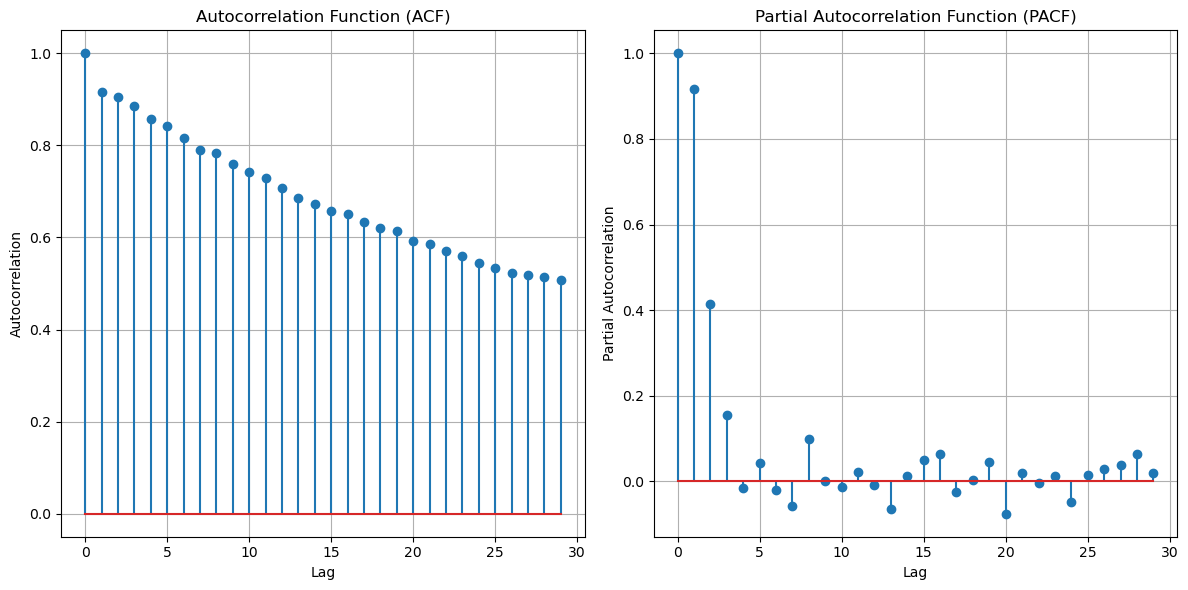

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
acf_values = acf(selected['feature_05'].diff())
pacf_values = pacf(selected['feature_05'].diff())
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot ACF
ax[0].stem(range(len(acf_values)), acf_values)
ax[0].set_title("Autocorrelation Function (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
ax[0].grid()

# Plot PACF
ax[1].stem(range(len(pacf_values)), pacf_values)
ax[1].set_title("Partial Autocorrelation Function (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
ax[1].grid()

plt.tight_layout()
plt.show()

In [21]:
def stationarity(df, threshold=0.1):
    results = {}
    # Filter only numeric columns
    numeric_df = df.select_dtypes(include='number')
    
    for col in numeric_df.columns:
        original_var = numeric_df[col].var()
        differenced_var = numeric_df[col].diff().var()
        results[col] = (differenced_var / original_var) < threshold
    
    return results
stationarity(selected)

C:\Users\D24HA010187\AppData\Local\Temp\ipykernel_5376\3897261274.py:9: RuntimeWarning: invalid value encountered in scalar divide
  results[col] = (differenced_var / original_var) < threshold


{'date_id': False,
 'time_id': True,
 'symbol_id': False,
 'weight': False,
 'feature_05': False,
 'feature_06': False,
 'feature_07': False,
 'feature_08': False,
 'feature_09': False,
 'feature_10': False,
 'feature_11': False,
 'feature_12': False,
 'feature_13': False,
 'feature_14': False,
 'feature_15': False,
 'feature_16': False,
 'feature_17': False,
 'feature_18': False,
 'feature_19': False,
 'feature_20': False,
 'feature_22': False,
 'feature_23': False,
 'feature_24': False,
 'feature_25': False,
 'feature_28': False,
 'feature_29': False,
 'feature_30': False,
 'feature_32': False,
 'feature_33': False,
 'feature_34': False,
 'feature_35': False,
 'feature_36': False,
 'feature_37': True,
 'feature_38': True,
 'feature_39': True,
 'feature_40': False,
 'feature_41': False,
 'feature_42': False,
 'feature_43': False,
 'feature_44': False,
 'feature_45': True,
 'feature_46': False,
 'feature_47': False,
 'feature_48': False,
 'feature_49': False,
 'feature_50': False,
 'fe

In [ ]:
tbl = tbl.iloc[:,:92]
X = tbl.iloc[:,:-8]
y = tbl.iloc[:,-8:]

In [20]:

from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
from sklearn.model_selection import TimeSeriesSplit
import torch
import numpy as np

In [42]:
cutoff = -100000
train_dataset = TensorDataset(torch.tensor(X[:cutoff].values), torch.tensor(y[:cutoff].values))
val_dataset = TensorDataset(torch.tensor(X[cutoff:].values), torch.tensor(y[cutoff:].values))

In [43]:
bs =2048
trainloader = DataLoader(train_dataset, batch_size=bs, shuffle=False)
valloader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

In [44]:
# tscv = TimeSeriesSplit(n_splits=5, test_size = X.shape[0]//200)
# combine the indices for the 5 splits into one for train and val, and initialize ONE dataloader

In [45]:
X.shape

(1944210, 84)

In [46]:
X.shape

(1944210, 84)

In [19]:
train_idx.shape

(1895605,)

In [ ]:
train_subset = Subset(dataset, tscv.split(X)[0][0])